In [1]:
import warnings
    
# Settings the warnings to be ignored
warnings.filterwarnings('ignore')

# primary modules

#utils
from tqdm.notebook import tqdm

# second part
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import statsmodels.tsa.api as ts

from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

from darts.metrics.metrics import rmse, r2_score
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel


import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import RMSE, MAE, SMAPE, MultivariateNormalDistributionLoss


In [2]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})


### 1. Data import & Preprocessing

In [3]:
%%time
df = pd.read_csv('./data/full_data_sum.csv')
# df = df.drop(columns=['Unnamed: 0', 'time', 'country_code'])
df['date'] = pd.to_datetime(df['date'])
df['dt'] = pd.to_datetime(df.date) + df.hour.astype('timedelta64[h]')

CPU times: user 1.59 s, sys: 178 ms, total: 1.77 s
Wall time: 1.81 s


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3137833 entries, 0 to 3137832
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   square_id  int64         
 1   date       datetime64[ns]
 2   hour       int64         
 3   sms_in     float64       
 4   sms_out    float64       
 5   call_in    float64       
 6   call_out   float64       
 7   internet   float64       
 8   dt         datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(2)
memory usage: 215.5 MB


In [5]:
dates = sorted(df.dt.unique())
dates[0]

numpy.datetime64('2013-10-31T23:00:00.000000000')

In [6]:

# get time_idx
dates_transformer = LabelEncoder()
df['time_idx'] = dates_transformer.fit_transform(df.dt)
df['time_idx'] += 1


# min_date = df.dt.min()
# df["time_idx2"] = df.dt.map(lambda current_date: (current_date - min_date) / np.timedelta64(1, 'h') )

In [7]:
# make categories str
df['square_id'] = df['square_id'].astype(str)

In [8]:
dates = sorted(df.date.unique())
train_dates = dates[:49]
val_dates = dates[49:]

train = df[df.date.isin(train_dates)]
val = df[df.date.isin(val_dates)]

In [9]:
train_cutoff = train['time_idx'].max()

### 2. Create time series DataSet

In [10]:
# станции которые не сильно между собой коррелируют
to_select = ['internet_6974', 'internet_6554', 'internet_8966', 'internet_7445', 'internet_9361', 'internet_5557', 'internet_8847', 'internet_6875', 'internet_3862', 'internet_3527', 'internet_6274', 'internet_7155', 'internet_8087', 'internet_6071', 'internet_5445', 'internet_6745', 'internet_9986', 'internet_4349', 'internet_4972', 'internet_3234', 'internet_8045', 'internet_8380', 'internet_9877', 'internet_4639', 'internet_7987', 'internet_4657', 'internet_9398', 'internet_6077', 'internet_4478', 'internet_1684', 'internet_3958', 'internet_3258', 'internet_3554', 'internet_6754', 'internet_8176', 'internet_5473', 'internet_6846', 'internet_8502', 'internet_4144', 'internet_2247', 'internet_4664', 'internet_3957', 'internet_4973', 'internet_6472', 'internet_8046', 'internet_8242', 'internet_2145', 'internet_9778', 'internet_7552', 'internet_9869', 'internet_8958', 'internet_7055', 'internet_6836', 'internet_5451', 'internet_4040', 'internet_3532', 'internet_8891', 'internet_8757', 'internet_7167', 'internet_9150', 'internet_6467', 'internet_9474', 'internet_7154', 'internet_4345', 'internet_8558', 'internet_3928', 'internet_5443', 'internet_9785', 'internet_7424', 'internet_6664', 'internet_6546', 'internet_4830', 'internet_2654', 'internet_5245', 'internet_4128', 'internet_5368', 'internet_5447', 'internet_48', 'internet_7161', 'internet_8152', 'internet_4446', 'internet_4341', 'internet_4667', 'internet_5646', 'internet_7271', 'internet_6766', 'internet_6250', 'internet_6662', 'internet_7173', 'internet_7769', 'internet_6050', 'internet_4061', 'internet_8273', 'internet_4367', 'internet_3755', 'internet_3334', 'internet_8561', 'internet_4578', 'internet_3462', 'internet_8311', 'internet_7085', 'internet_3966', 'internet_3551', 'internet_6473', 'internet_8464', 'internet_8283', 'internet_8247', 'internet_7672', 'internet_8148', 'internet_4464', 'internet_7786', 'internet_4563', 'internet_3945', 'internet_6252', 'internet_4874', 'internet_6466', 'internet_5047', 'internet_3929', 'internet_8673', 'internet_6465', 'internet_5649', 'internet_7562', 'internet_3674', 'internet_8534', 'internet_3558', 'internet_7722', 'internet_4550', 'internet_8056', 'internet_3353', 'internet_7389', 'internet_5344', 'internet_4047', 'internet_6470', 'internet_3967', 'internet_6053', 'internet_4279', 'internet_8332', 'internet_6854', 'internet_7226', 'internet_8854', 'internet_6852', 'internet_3233', 'internet_6054', 'internet_7144', 'internet_4658', 'internet_7980', 'internet_6270', 'internet_5848', 'internet_6585', 'internet_7306', 'internet_5457', 'internet_7468', 'internet_6645', 'internet_5145', 'internet_6055', 'internet_5357', 'internet_4343', 'internet_4029', 'internet_3118', 'internet_3553', 'internet_4058', 'internet_6052', 'internet_4129', 'internet_3836', 'internet_5851', 'internet_3868', 'internet_4362', 'internet_6953', 'internet_6451', 'internet_4443', 'internet_3360', 'internet_4444', 'internet_5544', 'internet_4351', 'internet_9483', 'internet_9684', 'internet_6775', 'internet_3659', 'internet_4669', 'internet_7822', 'internet_851', 'internet_4642', 'internet_7341', 'internet_8776', 'internet_4452', 'internet_5847', 'internet_4056', 'internet_2960', 'internet_5957', 'internet_3632', 'internet_4876', 'internet_4350', 'internet_6444', 'internet_3759', 'internet_6447', 'internet_7754', 'internet_7240', 'internet_8286', 'internet_6972', 'internet_8177', 'internet_3863', 'internet_8459', 'internet_4742', 'internet_5636', 'internet_3954', 'internet_8278', 'internet_6297', 'internet_6461', 'internet_6869', 'internet_3871', 'internet_7073', 'internet_9770', 'internet_6695', 'internet_7375', 'internet_8011', 'internet_6647', 'internet_7143', 'internet_7753', 'internet_7540', 'internet_6833', 'internet_8885', 'internet_8934', 'internet_4889', 'internet_1150', 'internet_4158', 'internet_4526', 'internet_4378', 'internet_9598', 'internet_8856', 'internet_5669', 'internet_4354', 'internet_3655', 'internet_6961', 'internet_4748', 'internet_1147', 'internet_8004', 'internet_3763', 'internet_8274', 'internet_1349', 'internet_8562', 'internet_6976', 'internet_9155', 'internet_8751', 'internet_5865', 'internet_7172', 'internet_6648', 'internet_4826', 'internet_3748', 'internet_8791', 'internet_4948', 'internet_4542', 'internet_3285', 'internet_4428', 'internet_4951', 'internet_5437', 'internet_7684', 'internet_7354', 'internet_6355', 'internet_5551', 'internet_4147', 'internet_7163', 'internet_7156', 'internet_8744', 'internet_4057', 'internet_7724', 'internet_3960', 'internet_6459', 'internet_4327', 'internet_9143', 'internet_4777', 'internet_5458', 'internet_3255', 'internet_1555', 'internet_4743', 'internet_5953', 'internet_4066', 'internet_7324', 'internet_4851', 'internet_6154', 'internet_4666', 'internet_6769', 'internet_5450', 'internet_7273', 'internet_7075', 'internet_4678', 'internet_8746', 'internet_5755', 'internet_4453', 'internet_8013', 'internet_7551', 'internet_3432', 'internet_5947', 'internet_7046', 'internet_4871', 'internet_3661', 'internet_3854', 'internet_3767', 'internet_8374', 'internet_5948', 'internet_7556', 'internet_4852', 'internet_3845', 'internet_6663', 'internet_4243', 'internet_8688', 'internet_9351', 'internet_6260', 'internet_6371', 'internet_4027', 'internet_4565', 'internet_5543', 'internet_3962', 'internet_3828', 'internet_4344', 'internet_5372', 'internet_7256', 'internet_5977', 'internet_8049', 'internet_6877', 'internet_4726', 'internet_6572', 'internet_8441', 'internet_5550', 'internet_4379', 'internet_6966', 'internet_8410', 'internet_7305', 'internet_4143', 'internet_8051', 'internet_8833', 'internet_5741', 'internet_3427', 'internet_8085', 'internet_7453', 'internet_7353', 'internet_8435', 'internet_6872', 'internet_5273', 'internet_6756', 'internet_4068', 'internet_3347', 'internet_7852', 'internet_5750', 'internet_6862', 'internet_6046', 'internet_5653', 'internet_4276', 'internet_5753', 'internet_7813', 'internet_9266', 'internet_5146', 'internet_8835', 'internet_8271', 'internet_3671', 'internet_6150', 'internet_8071', 'internet_6671', 'internet_3765', 'internet_3654', 'internet_6152', 'internet_7065', 'internet_8635', 'internet_6153', 'internet_3733', 'internet_7265', 'internet_7064', 'internet_5028', 'internet_6971', 'internet_3970', 'internet_4733', 'internet_6151', 'internet_4228', 'internet_6533', 'internet_8312', 'internet_8756', 'internet_3548', 'internet_7623', 'internet_6372', 'internet_4553', 'internet_3959', 'internet_3673', 'internet_4226', 'internet_7342', 'internet_6755', 'internet_6771', 'internet_6367', 'internet_8047', 'internet_6853']
to_select = [i.split('_')[1] for i in to_select]

In [11]:
# есть ряды где часть значений пропущена
broken_squares = train.groupby('square_id').time_idx.nunique()[train.groupby('square_id').time_idx.nunique() != 1153].values
train = train[~train.square_id.isin(broken_squares)]

In [12]:
train = train[~train.square_id.isin(broken_squares)]
train = train[train.square_id.isin(to_select)]

val = val[~val.square_id.isin(broken_squares)]
val = val[val.square_id.isin(to_select)]

df = df[~df.square_id.isin(broken_squares)]
df = df[df.square_id.isin(to_select)]

In [13]:
# create dataset and dataloaders
max_encoder_length = 72
max_prediction_length = 24


context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    train,
    time_idx="time_idx",
    target="internet",
    categorical_encoders={"square_id": NaNLabelEncoder().fit(train.square_id)},
    group_ids=["square_id"],
    static_categoricals=[
        "square_id"
    ],  
    time_varying_unknown_reals=["internet"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    allow_missing_timesteps=False
)

validation = TimeSeriesDataSet.from_dataset(training, df, min_prediction_idx=train_cutoff + 1)

In [14]:
random_bs = np.random.choice(df.square_id.unique(), 129)
validation_sample = TimeSeriesDataSet.from_dataset(training, df[df.square_id.isin(random_bs)], min_prediction_idx=train_cutoff + 1)


In [15]:
# dataset len counting
training.__len__() == \
train.square_id.nunique() * (train.groupby('square_id').size()[0] - max_encoder_length - max_prediction_length + 1)


True

In [16]:
validation.__len__() == \
val.square_id.nunique() * (val.groupby('square_id').size()[0] - max_prediction_length + 1)

True

In [17]:
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, 
    batch_size=batch_size, 
    num_workers=4,
    drop_last=True, 
    batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=4, batch_sampler="synchronized"
)

x, y = next(iter(val_dataloader))
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

	encoder_cat = torch.Size([128, 72, 1])
	encoder_cont = torch.Size([128, 72, 1])
	encoder_target = torch.Size([128, 72])
	encoder_lengths = torch.Size([128])
	decoder_cat = torch.Size([128, 24, 1])
	decoder_cont = torch.Size([128, 24, 1])
	decoder_target = torch.Size([128, 24])
	decoder_lengths = torch.Size([128])
	decoder_time_idx = torch.Size([128, 24])
	groups = torch.Size([128, 1])
	target_scale = torch.Size([128, 2])


In [18]:
%%time
subset_data_loader = validation_sample.to_dataloader(
    train=False, batch_size=112, num_workers=4, batch_sampler="synchronized"
)

x, y = next(iter(subset_data_loader))
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

	encoder_cat = torch.Size([112, 72, 1])
	encoder_cont = torch.Size([112, 72, 1])
	encoder_target = torch.Size([112, 72])
	encoder_lengths = torch.Size([112])
	decoder_cat = torch.Size([112, 24, 1])
	decoder_cont = torch.Size([112, 24, 1])
	decoder_target = torch.Size([112, 24])
	decoder_lengths = torch.Size([112])
	decoder_time_idx = torch.Size([112, 24])
	groups = torch.Size([112, 1])
	target_scale = torch.Size([112, 2])
CPU times: user 11.8 ms, sys: 35.3 ms, total: 47 ms
Wall time: 10.3 s


### 3. Calculate baseline error

In [19]:
%%time
answers = []
for x, y in tqdm(subset_data_loader):
    target = y
    answers.append(target[0])

val_answers = torch.cat(answers, axis=0)


  0%|          | 0/624 [00:00<?, ?it/s]

CPU times: user 249 ms, sys: 163 ms, total: 412 ms
Wall time: 13.8 s


In [20]:
%%time
full_rows = {}

for x, y in tqdm(subset_data_loader):
    for key in x.keys():
        if key not in full_rows:
            full_rows[key] = []
        full_rows[key].append(x[key])


  0%|          | 0/624 [00:00<?, ?it/s]

CPU times: user 299 ms, sys: 175 ms, total: 474 ms
Wall time: 14.5 s


In [21]:
type(subset_data_loader.dataset )

pytorch_forecasting.data.timeseries.TimeSeriesDataSet

In [22]:
validation.target

'internet'

In [23]:
%%time
baseline_predictions = Baseline().predict(subset_data_loader, 
                                          trainer_kwargs=dict(accelerator="cpu"), 
                                          return_y=False)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CPU times: user 814 ms, sys: 375 ms, total: 1.19 s
Wall time: 26.5 s


In [24]:
from pytorch_forecasting.metrics import RMSE

In [25]:
val_answers = val_answers.to('cpu')

In [26]:
RMSE()(baseline_predictions, val_answers)

tensor(371.6137)

In [27]:
from torchmetrics.functional import r2_score
loss = r2_score(baseline_predictions, val_answers)
loss

tensor(0.5240)

### 4. Fit DeepAR

In [28]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=40,
    rnn_layers=5,
    optimizer="Adam",
)

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0017378008287493763
Restoring states from the checkpoint path at /Users/nikitamatveev/1Progs/diploma/.lr_find_cfbf6240-9968-4910-8ac6-a8d8f33f95c5.ckpt
Restored all states from the checkpoint at /Users/nikitamatveev/1Progs/diploma/.lr_find_cfbf6240-9968-4910-8ac6-a8d8f33f95c5.ckpt


suggested learning rate: 0.0017378008287493763


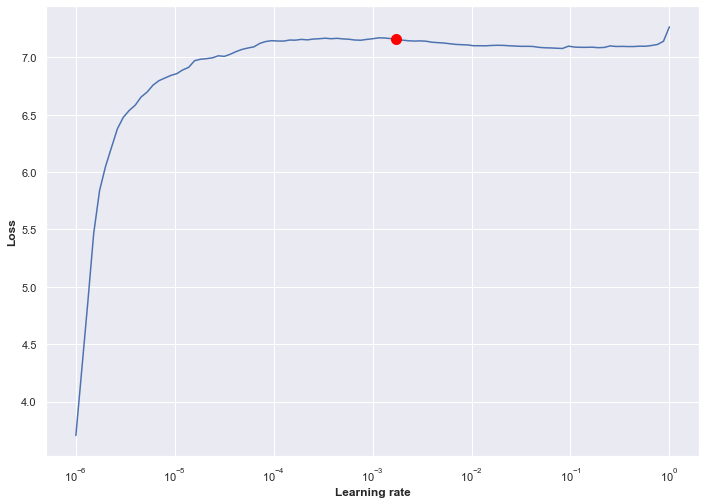

In [29]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-6,
    max_lr=1e0,
    early_stop_threshold=10,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [30]:
# код обучения при перезапуске не используется, подтягивается уже обученная модель

from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger('logs_ar', name='Break fitting')

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=1, #
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=300,
    limit_val_batches=100,
    enable_checkpointing=True,
    logger=logger
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=subset_data_loader
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs_ar/Break fitting

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 17.5 K
3 | rnn                    | LSTM                   | 66.6 K
4 | distribution_projector | Linear                 | 82    
------------------------------------------------------------------
84.1 K    Trainable params
0         Non-trainable params
84.1 K    Total params
0.336     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [42]:
import json 
with open('./program/config.json', "r") as file:
    config = json.load(file)



In [44]:
# best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path = config["model_path"]
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [45]:
ar_predictions = best_model.predict(subset_data_loader, 
                             trainer_kwargs=dict(accelerator="cpu"), 
                             return_y=False)

print(RMSE()(ar_predictions, val_answers))

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(228.9706)


In [46]:
print(MAE()(ar_predictions, val_answers))

tensor(115.2565)


In [47]:
r2_score(ar_predictions, val_answers)

tensor(0.8174)

In [62]:
full_rows['encoder_lengths'] = full_rows['encoder_lengths'][0]
full_rows['decoder_lengths'] = full_rows['decoder_lengths'][0]

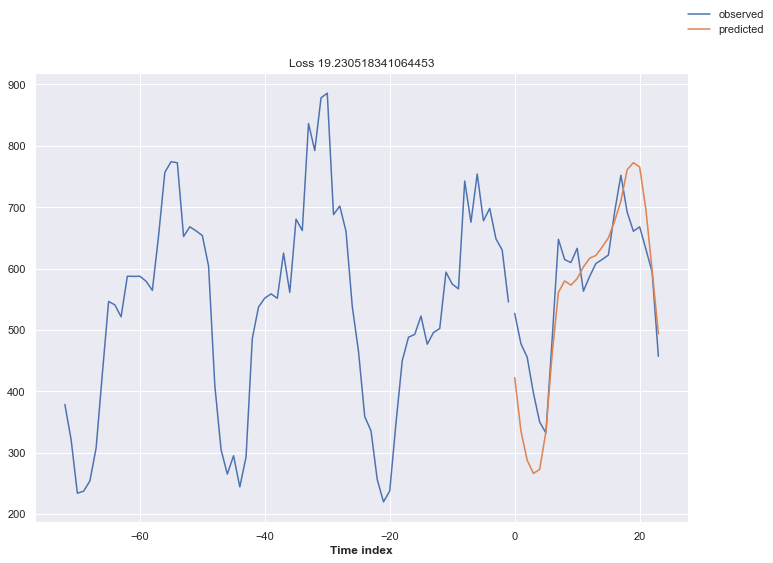

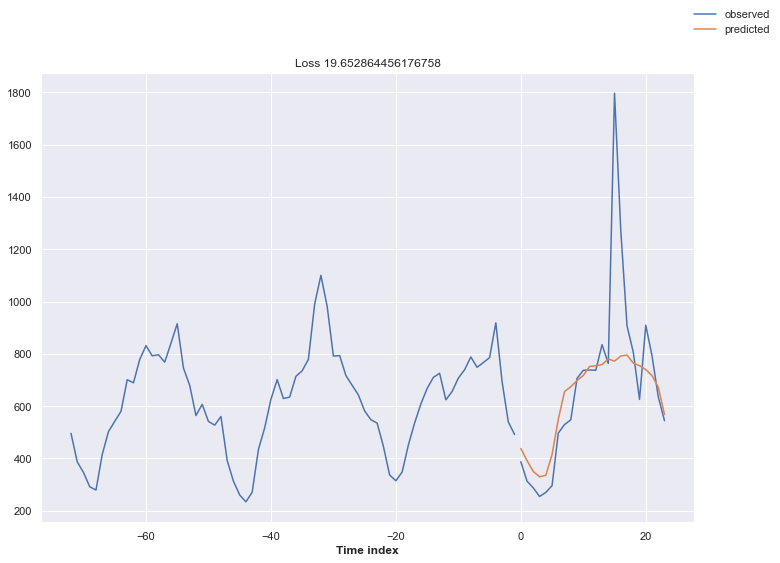

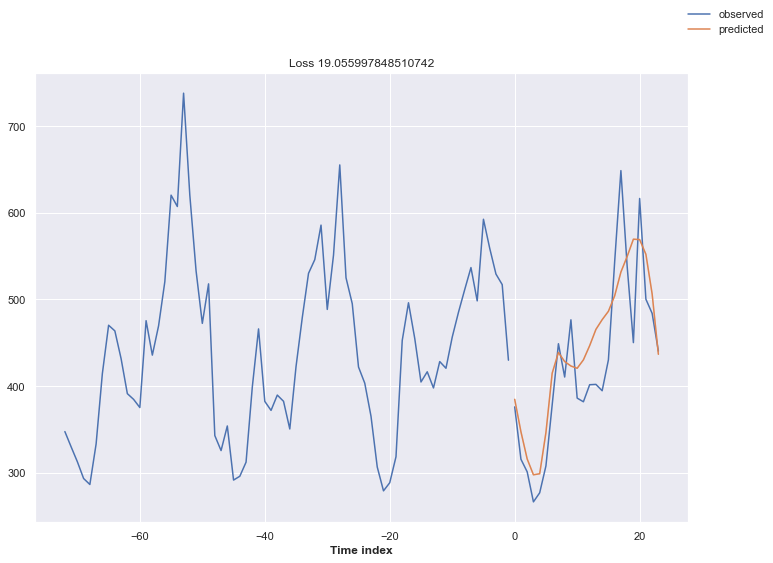

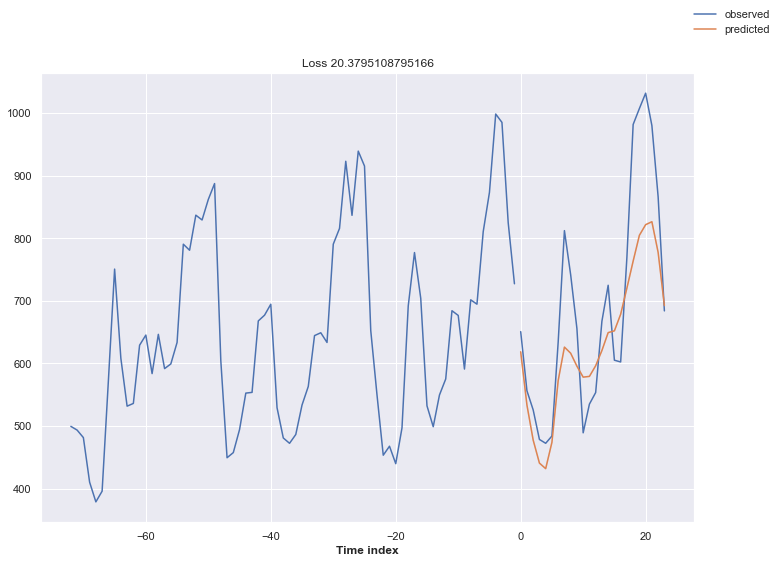

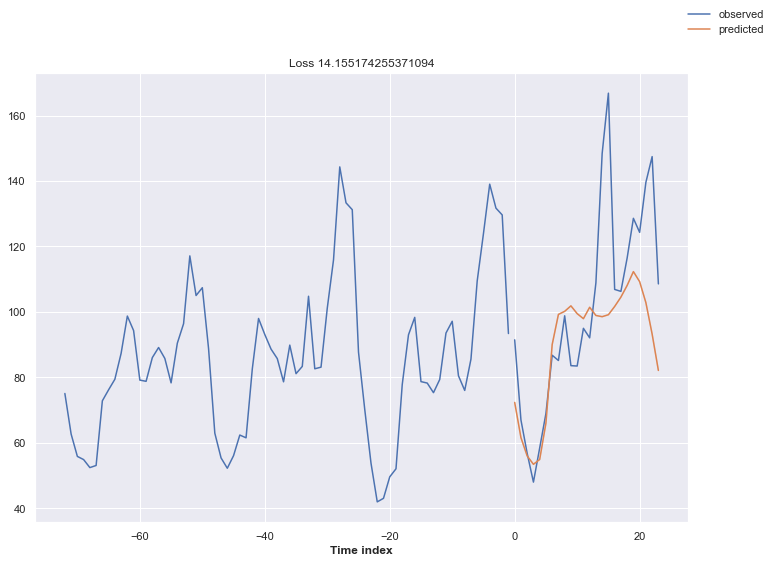

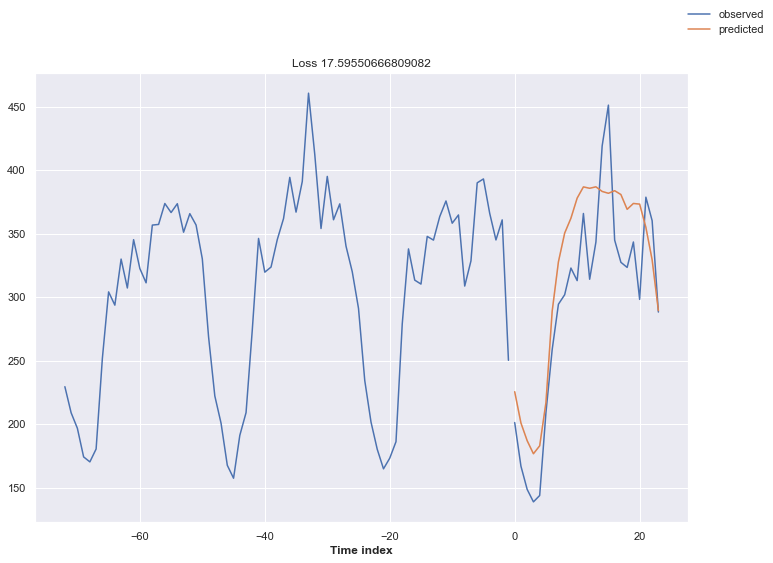

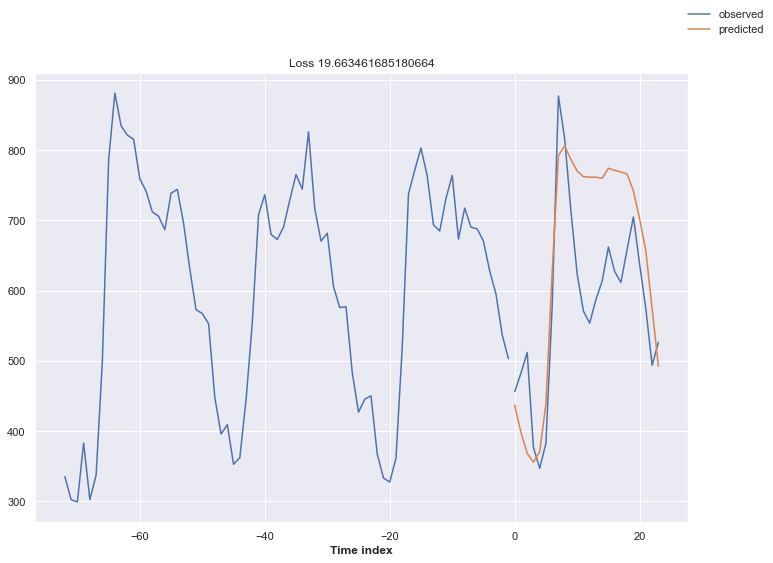

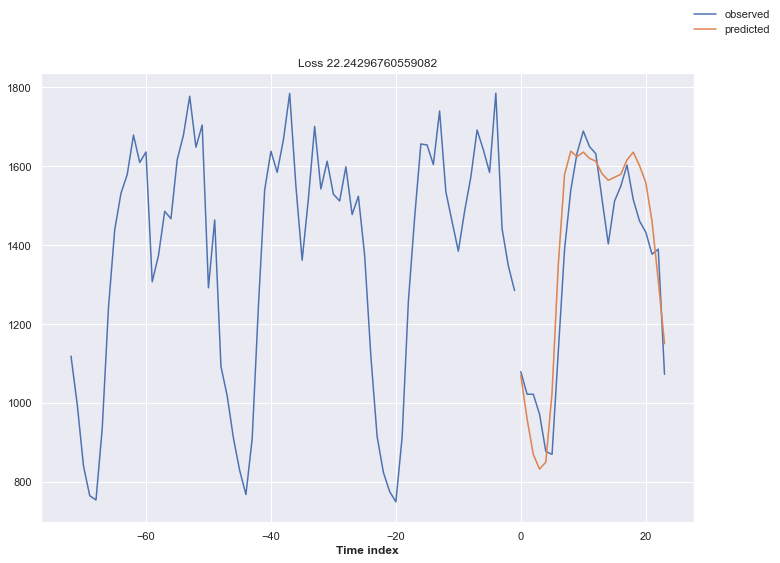

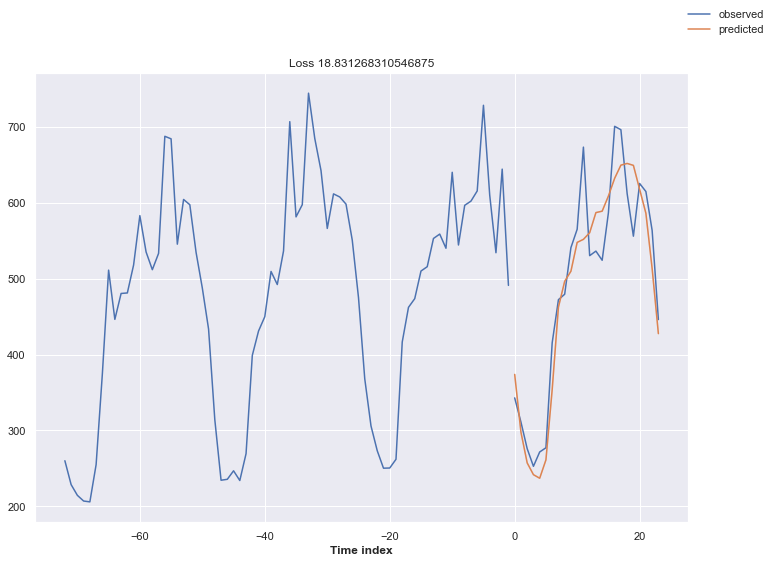

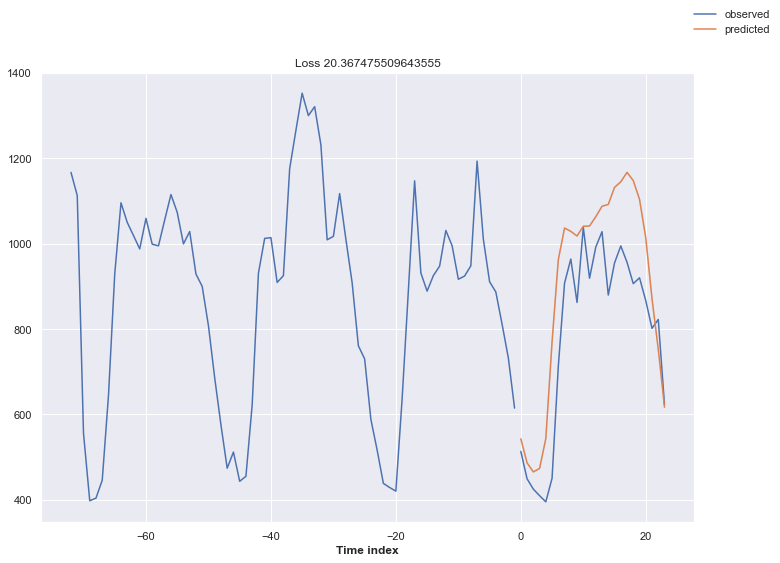

In [67]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(full_rows, {'prediction': ar_predictions}, idx=idx, add_loss_to_title=True)